In [1]:
import numpy as np
import pandas as pd
import json

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

#Sklearn tools
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

#keras
from keras.utils.np_utils import to_categorical

# Import supplementary visualizations code visuals.py
import visuals as vs

# util
import importlib
import plot_util # Make predictions
from eval_metrics import EvalMetrics


# For final model
from keras.models import Sequential
from keras.layers import Dropout, Dense, Activation
from FFClassifier import FFClassifier as FFC
import importlib


Using TensorFlow backend.


# 1. Load Data

In [2]:
# Load unseen dataset
cdr_6 = pd.read_csv('data/sms-call-internet-mi-2013-11-06.csv')

In [3]:
print("Dataset length: ",len(cdr_6))
cdr_6.head()

Dataset length:  2417156


,datetime,CellID,countrycode,smsin,smsout,callin,callout,internet
0,2013-11-06 00:00:00,1,0,0.0814,NaN,NaN,NaN,NaN
1,2013-11-06 00:00:00,1,39,0.7458,0.7204,0.1626,0.1057,52.3219
2,2013-11-06 00:00:00,2,0,0.0829,NaN,NaN,NaN,NaN
3,2013-11-06 00:00:00,2,39,0.7653,0.7409,0.1639,0.1094,52.4064
4,2013-11-06 00:00:00,3,0,0.0846,NaN,NaN,NaN,NaN


# 2. Clean Data

In [4]:
# drop irrelevant features
cdr_6 = cdr_6.drop(['datetime'], axis=1)

In [5]:
# drop NaN records
cdr_6 = cdr_6.dropna(axis=0)

In [6]:
print("Dataset length: ",len(cdr_6))
cdr_6.head()

Dataset length:  231428


,CellID,countrycode,smsin,smsout,callin,callout,internet
1,1,39,0.7458,0.7204,0.1626,0.1057,52.3219
3,2,39,0.7653,0.7409,0.1639,0.1094,52.4064
5,3,39,0.7861,0.7628,0.1652,0.1133,52.4964
7,4,39,0.6893,0.6608,0.1591,0.0951,52.0770
9,5,39,0.6345,0.6198,0.1400,0.0918,47.0682


# 3. Normalize and Reduce Data Dimension

In [7]:
# Scale data 
non_zero_constant = 1
log_data = np.log(cdr_6 + non_zero_constant)

In [8]:
# apply PCA

pca = PCA(n_components=3)
pca = pca.fit(log_data)

# Transform the log data using the PCA fit above
reduced_data = pca.transform(log_data)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2',  'Dimension 3'])

# 4. Create Clusters

In [9]:
# create clusters
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

def do_clustering(k, _sample_size):
    global clusterer, preds, centers, score
    # Apply your clustering algorithm of choice to the reduced data 
    clusterer = GaussianMixture(n_components=k, random_state=42).fit(reduced_data)

    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)

    # Find the cluster centers
    centers = clusterer.means_

    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, sample_size =_sample_size)
    
    print("For k = {}, silhouette_score = {}".format(k,score))

In [10]:
do_clustering(2, 20000)

For k = 2, silhouette_score = 0.3942986055312106


# 5. Display Clustering Result

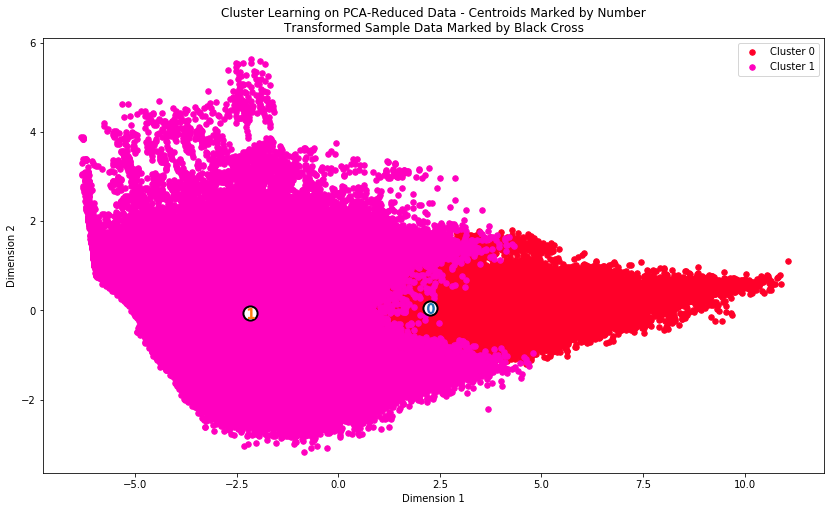

In [11]:
vs.cluster_results(reduced_data, preds, centers, None)

# 6. Recover Data

In [12]:
# Define Centroids
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers) - non_zero_constant

# Display the true centers
segments = ['Cluster {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns =cdr_6.keys())
true_centers.index = segments
display(true_centers)

,CellID,countrycode,smsin,smsout,callin,callout,internet
Cluster 0,5597.0,39.0,24.0,18.0,24.0,26.0,388.0
Cluster 1,2588.0,39.0,2.0,2.0,2.0,2.0,78.0


In [13]:
nan_records = [ p  for p in preds if p is None]
zeros =  [ p  for p in preds if p == 0]
ones =  [ p  for p in preds if p == 1]

# Very that all records have predictions
print(len(preds))
print(len(ones)+len(zeros))

231428
231428


In [14]:
### Extract label data

# Change label IDs for training purposes
# 1 == Likely Customers
# 0 == Unlikely Customers
flipped_preds = [ p^1 for p in preds]
zeros =  [ p  for p in flipped_preds if p == 0]
ones =  [ p  for p in flipped_preds if p == 1]

# Verify that all records have predictions
print(len(flipped_preds))
print(len(ones)+len(zeros))


231428
231428


In [15]:
# Store labels
label = pd.Series(flipped_preds)
log_data['label'] = label
log_data[log_data.label == 1].head()

,CellID,countrycode,smsin,smsout,callin,callout,internet,label
2832,6.637258,3.688879,0.813593,1.285894,0.631644,0.500715,5.383246,1.0
2931,6.669498,3.688879,0.083238,0.073622,0.099212,0.064945,2.756618,1.0
3028,6.701960,3.688879,0.223623,0.109572,0.020097,0.141152,3.039711,1.0
3125,6.739337,3.688879,0.437351,2.677735,0.342312,0.380626,4.643667,1.0
3218,6.766192,3.688879,1.971369,1.644438,0.837853,0.725324,5.831269,1.0


In [16]:
#reverse log_data
original_data = log_data.drop(['label'], axis=1)
original_data = np.exp(original_data) - non_zero_constant
#original_data['label'] = label
#original_data[original_data.label ==1].head(n=25)





# 7. Load Hybrid Model From Checkpoint

In [17]:
# params
_input_dims = 7
_num_classes = 2
_dropout = 0.2
inp_dim = 7
optimizer = 'Adam' 
loss = 'categorical_crossentropy'
metrics = ['accuracy']
checkpoint = 'saved_models/hybrid_model.ckpt'

# model structure
ffclassifier = FFC(None,None,None,None, _num_classes,_dropout)
ffclassifier.create_model(inp_dim)
ffclassifier.model.load_weights('saved_models/hybrid_model.ckpt')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                512       
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
__________

# 8. Make Predictions On Unseen Data

In [18]:
# Split unseen data
# Separate target (y) and independent variables (X)
X = original_data.iloc[:,:7].values
y = np.array(flipped_preds)

In [19]:
# Predict
_preds = ffclassifier.model.predict(X) 
hybrid_preds = np.argmax(_preds, axis=1)


# 9. Plot Confusion Matrix

Confusion matrix, without normalization
[[106833  11280]
 [  1617 111698]]


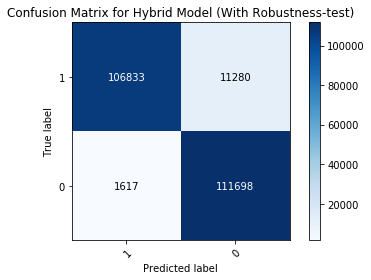

In [23]:
_, cm_hybrid = plot_util.plot_confusion_matrix(y, hybrid_preds, classes=np.array([1,0]), 
                                        title="Confusion Matrix for Hybrid Model (With Robustness-test)")

From the Matrix Above:

- True Positive (TP) = 106833
- False Positive (FP) = 1617
- True Negative (TN) =  111698
- False Negative (FN) =  11280

In [21]:
# Compute Eval Metrics

hybrid_metrics = EvalMetrics(cm_hybrid[0][0], cm_hybrid[1][0], cm_hybrid[1][1], cm_hybrid[0][1])

print("Accuracy = {:.2f}%\nPrecision = {:.2f}%\nRecall = {:.2f}%\nF1-Score = {:.2f}%\n"
      .format(100*hybrid_metrics.get_accuracy(), 100*hybrid_metrics.get_precision(),
       100*hybrid_metrics.get_recall(), 100*hybrid_metrics.get_f1_score()))


Accuracy = 94.43%
Precision = 98.51%
Recall = 90.45%
F1-Score = 94.31%



In [22]:

#importlib.reload(eval_metrics)